The data sets chosen for analysis and explanation include the monthly recorded numbers for the production of cars, the number of unemployed people aged 15 or above (in thousands), and the amount of imported gold (in kg). The data sets cover the period from January 2020 to January 2024 (inclusive). 

In [167]:
require(openxlsx)
require(data.table)
require(ggplot2)
require(GGally)
require(fable)
require(lubridate)
require(forecast)
require(skimr)
require(repr)

In [168]:
data_path <- "data.xlsx"
dt <- data.table(read.xlsx(data_path, sheet = "EVDS"))
dt$t <- 1:nrow(dt)
str(dt)
head(dt)

Classes 'data.table' and 'data.frame':	49 obs. of  10 variables:
 $ Tarih          : chr  "2020-01" "2020-02" "2020-03" "2020-04" ...
 $ TP.YISGUCU2.G4 : num  4420 4239 3905 3698 3692 ...
 $ TP.HKFE01      : num  121 124 125 128 136 ...
 $ TP.UR.S08      : num  75396 87589 72093 9661 43264 ...
 $ TP.PR.ARZ01    : num  7.37e+08 7.87e+08 8.47e+08 1.00e+09 1.05e+09 ...
 $ TP.AC2.ANO.A   : num  1390 1271 1070 447 487 ...
 $ TP.MK.F.BILESIK: num  1191 1060 896 1011 1055 ...
 $ TP.DK.USD.A.YTL: num  5.92 6.04 6.31 6.82 6.95 ...
 $ TP.GOLDIMPRT.V1: num  29648 18873 26268 7308 11780 ...
 $ t              : int  1 2 3 4 5 6 7 8 9 10 ...
 - attr(*, ".internal.selfref")=<externalptr> 


Tarih,TP.YISGUCU2.G4,TP.HKFE01,TP.UR.S08,TP.PR.ARZ01,TP.AC2.ANO.A,TP.MK.F.BILESIK,TP.DK.USD.A.YTL,TP.GOLDIMPRT.V1,t
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
2020-01,4420,120.9,75396,736761246,1390,1191.40,5.918159,29647.63,1
2020-02,4239,123.7,87589,787440698,1271,1059.94,6.044470,18872.63,2
2020-03,3905,125.4,72093,847047260,1070,896.44,6.314432,26268.15,3
2020-04,3698,127.5,9661,1004180564,447,1011.10,6.818952,7308.34,4
2020-05,3692,135.9,43264,1049003890,487,1055.20,6.951947,11779.97,5
2020-06,4028,139.5,74264,1101587027,1312,1165.25,6.808832,21518.34,6


Before examining each data set individually, it is important to calculate the correlation between the data pairs and ensure that they are not linearly dependent on each other.

In [169]:
cor(dt[,'TP.GOLDIMPRT.V1'],dt[,'TP.YISGUCU2.G4'])
cor(dt[,'TP.GOLDIMPRT.V1'],dt[,'TP.UR.S08'])
cor(dt[,'TP.YISGUCU2.G4'],dt[,'TP.UR.S08'])

,TP.YISGUCU2.G4
TP.GOLDIMPRT.V1,-0.08926752


,TP.UR.S08
TP.GOLDIMPRT.V1,0.2836901


,TP.UR.S08
TP.YISGUCU2.G4,-0.1564518



The first data set to model is numbers for the production of cars. Some google trend key word searchs that could be utilized to explain the data are determined as car prices (araba fiyatları), loan for cars (araç kredisi), and lastly new cars (sıfır araba). Now the question to explore is that whether the producesd car amount is related to the amount of given google searchs or not.

In [170]:
dt1 <- data.table()
dt1[,'date':= dt[,'Tarih']]
dt1[,'car_production':= dt[,'TP.UR.S08']]

start_month <- "2020-01"
end_month <- "2024-01"

x1 <- fread('arabafiyatları.csv')
x1[, Month := format(Hafta, "%Y-%m")]
x1 <- x1[, .(Sum = sum(`araba fiyatları: (Türkiye)`)), by = Month]
x1 <- x1[Month %between% c(start_month, end_month)]

x2 <- fread('araçkredisi.csv')
x2[, Month := format(Hafta, "%Y-%m")]
x2 <- x2[, .(Sum = sum(`araç kredisi: (Türkiye)`)), by = Month]
x2 <- x2[Month %between% c(start_month, end_month)]

x3 <- fread('sıfıraraba.csv')
x3[, Month := format(Hafta, "%Y-%m")]
x3 <- x3[, .(Sum = sum(`sıfır araba: (Türkiye)`)), by = Month]
x3 <- x3[Month %between% c(start_month, end_month)]

dt1[,'search_car_prices':= x1[,'Sum']]
dt1[,'search_car_loans':= x2[,'Sum']]
dt1[,'search_new_cars':= x3[,'Sum']]
dt1$t <- 1:nrow(dt)

head(dt1)

date,car_production,search_car_prices,search_car_loans,search_new_cars,t
<chr>,<dbl>,<int>,<int>,<int>,<int>
2020-01,75396,174,47,133,1
2020-02,87589,187,48,147,2
2020-03,72093,206,42,145,3
2020-04,9661,150,29,91,4
2020-05,43264,301,155,237,5
2020-06,74264,320,200,287,6


To begin with the forecast variable and the regressor variables are plotted individually for visual inspection to decide the modelling strategies. Additionaly, autocorrelation function of the target variable is plotted for the same purpose.
After that a scatterplot matrix is also plotted to detect any linear relationships between independent variables and the forecast variable.

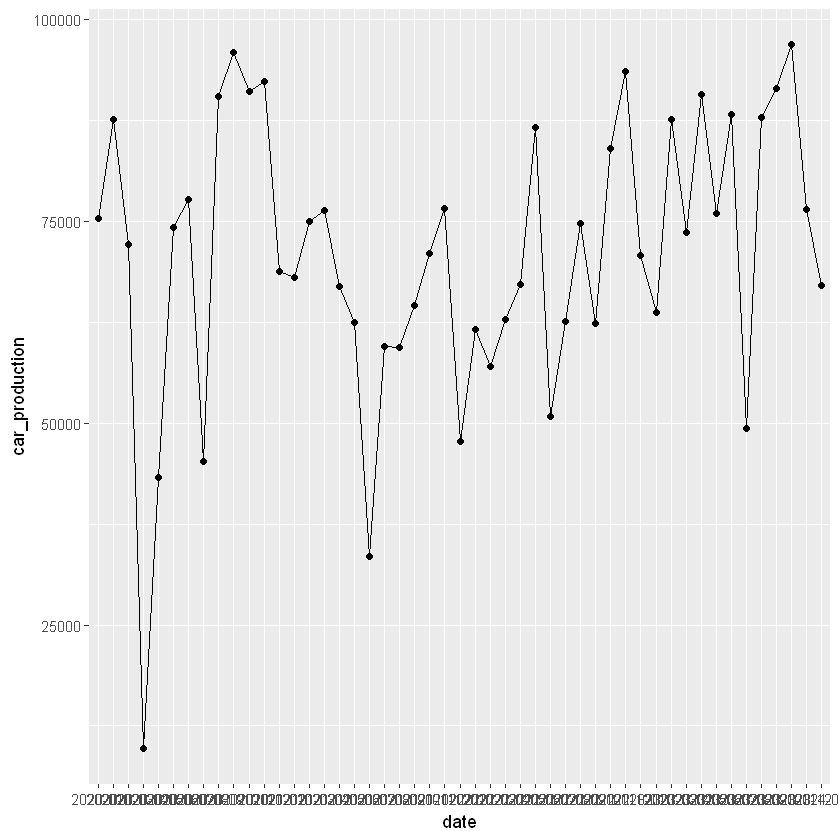

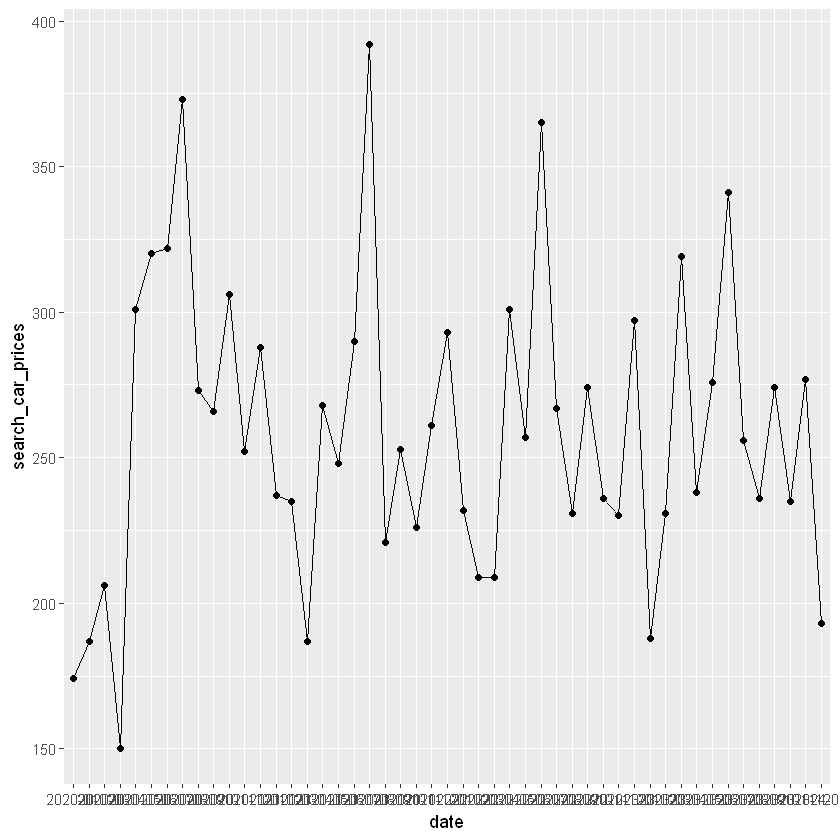

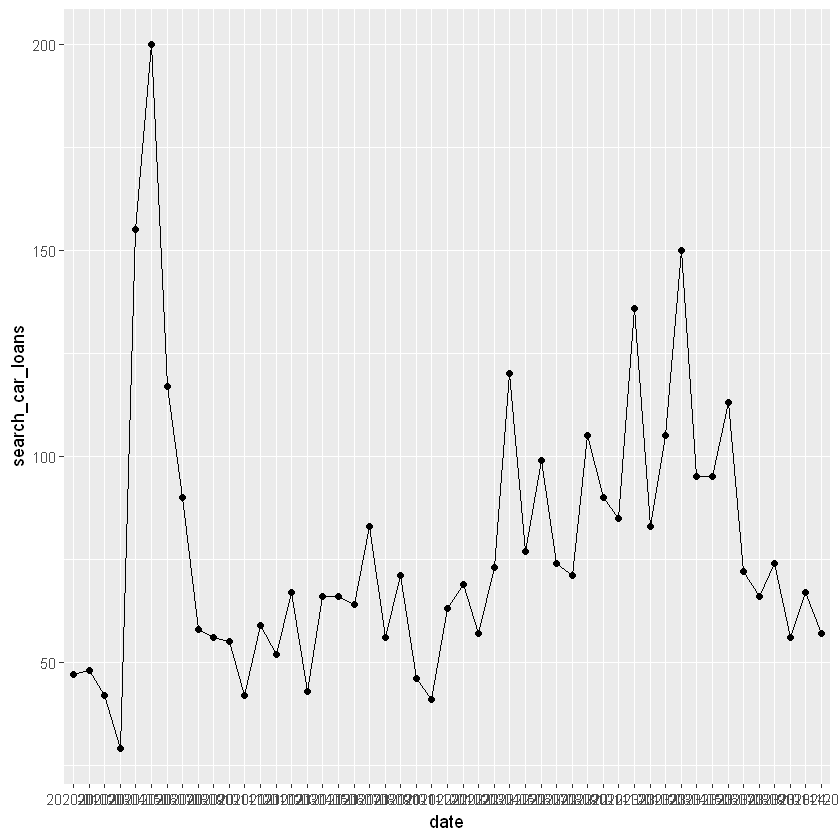

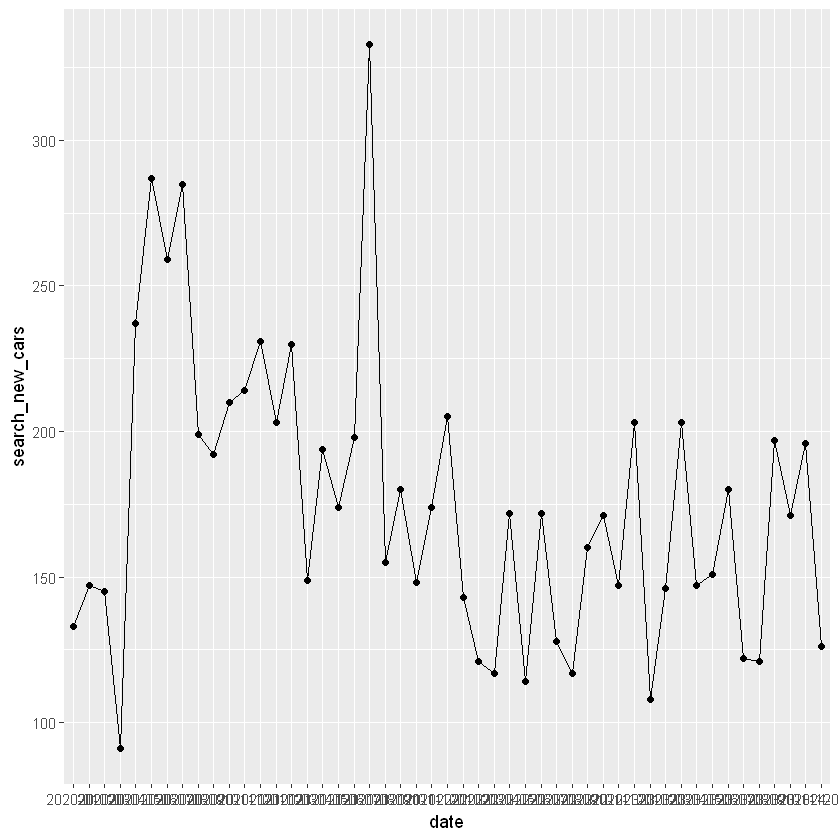

In [171]:
ggplot(dt1, aes(x = date, y = car_production, group=1)) + geom_line() + geom_point()
ggplot(dt1, aes(x = date, y = search_car_prices, group=1)) + geom_line() + geom_point()
ggplot(dt1, aes(x = date, y = search_car_loans, group=1)) + geom_line() + geom_point()
ggplot(dt1, aes(x = date, y = search_new_cars, group=1)) + geom_line() + geom_point()


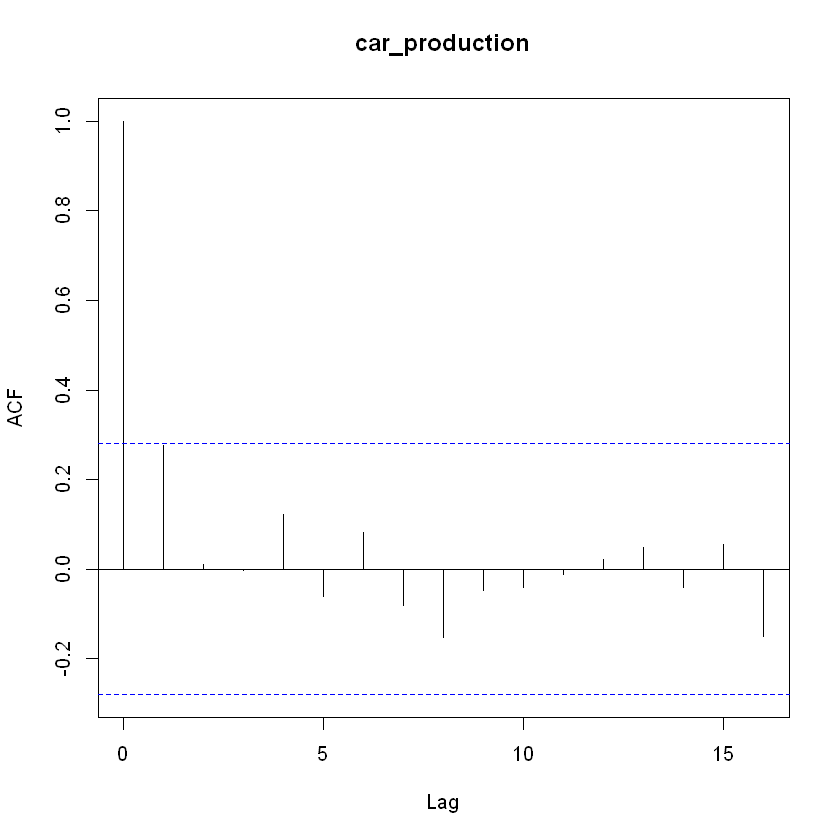

In [172]:
acf(dt1[,'car_production'])

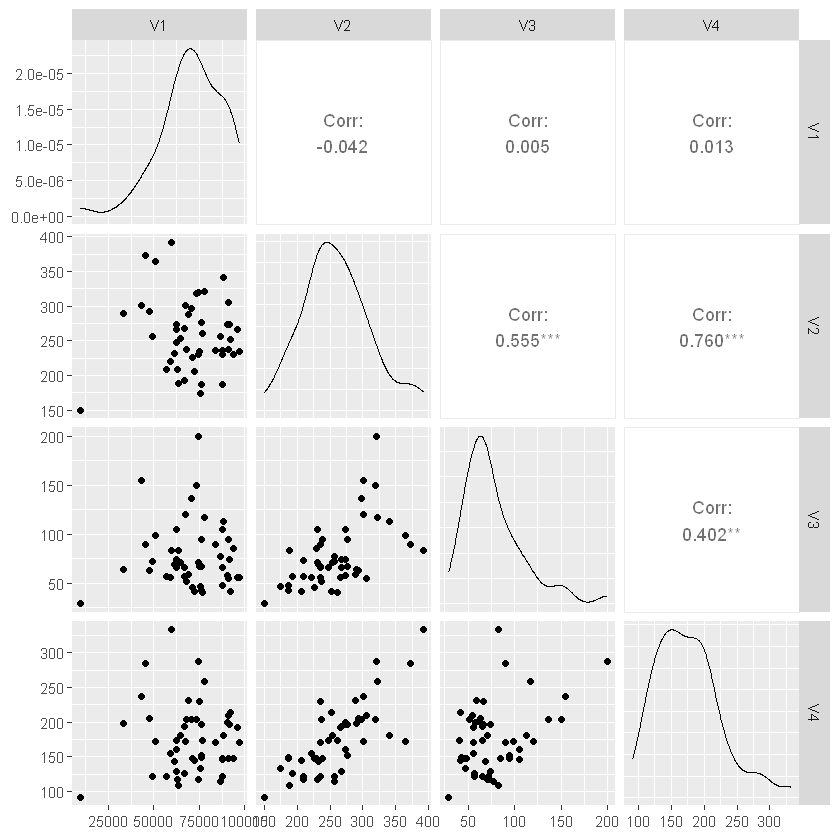

In [173]:
matrix1 <- data.table(dt1[,car_production],dt1[,search_car_prices],dt1[,search_car_loans],dt1[,search_new_cars])
ggpairs(matrix1)

There seems to be an upward trend in the data. 
Even though the correlation values between independent variables adn the forecast variable indicates unsignificant linear relationships, the first model is built including all three of the features as well as a trend variable.

In [174]:
model1 <- lm(car_production ~ t + search_car_prices + search_car_loans + search_new_cars, data = dt1)
summary(model1)



Call:
lm(formula = car_production ~ t + search_car_prices + search_car_loans + 
    search_new_cars, data = dt1)

Residuals:
   Min     1Q Median     3Q    Max 
-52040  -8064     23  11382  30506 

Coefficients:
                  Estimate Std. Error t value Pr(>|t|)    
(Intercept)       65142.71   13564.17   4.803 1.85e-05 ***
t                   500.16     215.43   2.322   0.0249 *  
search_car_prices  -131.91      88.56  -1.489   0.1435    
search_car_loans    -17.05      91.28  -0.187   0.8527    
search_new_cars     163.06      93.18   1.750   0.0871 .  
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 17140 on 44 degrees of freedom
Multiple R-squared:  0.1162,	Adjusted R-squared:  0.03589 
F-statistic: 1.447 on 4 and 44 DF,  p-value: 0.2347


When result of the model is interpretted none of the search variables has a small p-value to be considered as linearly related to the variable of interest as expected. Only the trend and the intercept variables are significant. Also R-squared and adjusted R-squared values are quite low which indicates an unsuccesful model.

After the interpretation of first model, it has been decided that using the car production amount shifted 4 months prior since a change in the stated google searchs may show their effect on the producton area with a certain delay. The same graphs are plotted again for the new shifted forecast variable.

Warning message:
"Removed 4 rows containing missing values or values outside the scale range
(`geom_line()`)."
Warning message:
"Removed 4 rows containing missing values or values outside the scale range
(`geom_point()`)."
Warning message:
"Removed 4 rows containing non-finite outside the scale range
(`stat_density()`)."
Warning message in ggally_statistic(data = data, mapping = mapping, na.rm = na.rm, :
"Removed 4 rows containing missing values"
Warning message in ggally_statistic(data = data, mapping = mapping, na.rm = na.rm, :
"Removed 4 rows containing missing values"
Warning message in ggally_statistic(data = data, mapping = mapping, na.rm = na.rm, :
"Removed 4 rows containing missing values"
Warning message:
"Removed 4 rows containing missing values or values outside the scale range
(`geom_point()`)."
Warning message:
"Removed 4 rows containing missing values or values outside the scale range
(`geom_point()`)."
Warning message:
"Removed 4 rows containing missing values or values 

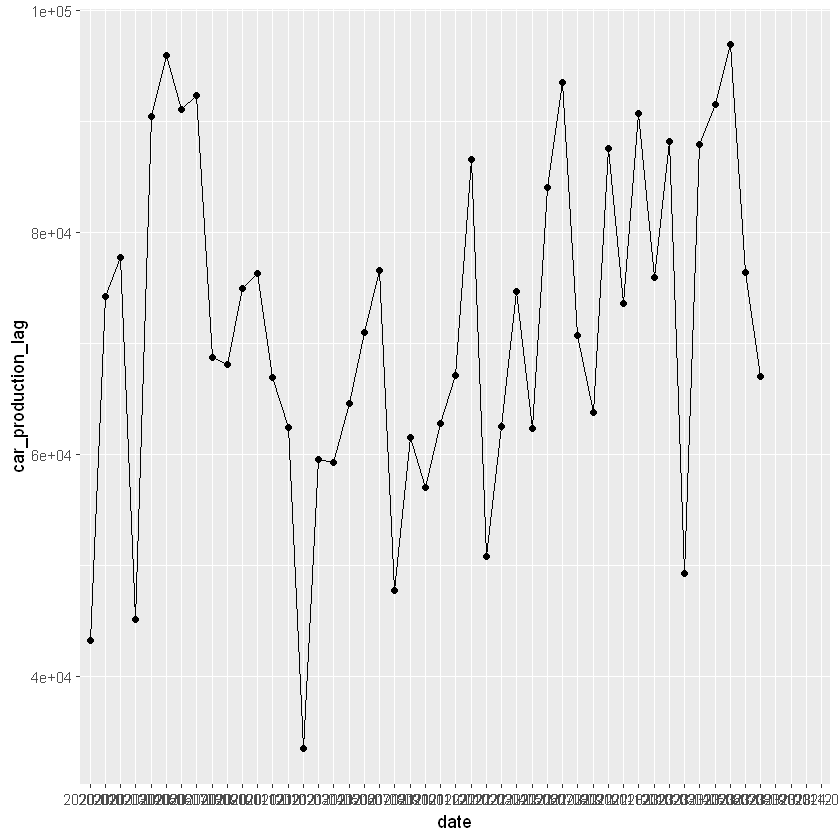

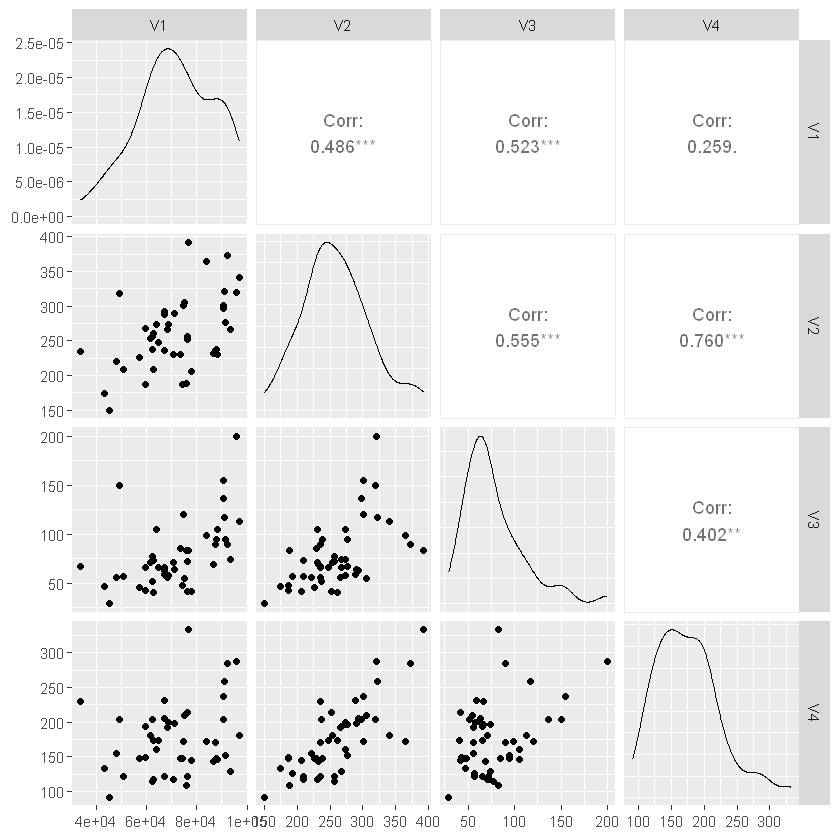

In [175]:
dt1[, car_production_lag := shift(car_production, n = -4)]
ggplot(dt1, aes(x = date, y = car_production_lag, group=1)) + geom_line() + geom_point()
matrix2 <- data.table(dt1[,car_production_lag],dt1[,search_car_prices],dt1[,search_car_loans],dt1[,search_new_cars])
ggpairs(matrix2)

In [176]:
model2 <- lm(car_production_lag ~ t + search_car_prices + search_car_loans , data = dt1)
summary(model2)


Call:
lm(formula = car_production_lag ~ t + search_car_prices + search_car_loans, 
    data = dt1)

Residuals:
   Min     1Q Median     3Q    Max 
-40223  -6650    555  10366  20962 

Coefficients:
                  Estimate Std. Error t value Pr(>|t|)   
(Intercept)       34359.34   10430.29   3.294  0.00204 **
t                   124.09     155.11   0.800  0.42832   
search_car_prices    86.32      44.92   1.922  0.06160 . 
search_car_loans    151.09      70.97   2.129  0.03932 * 
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 13030 on 41 degrees of freedom
  (4 observations deleted due to missingness)
Multiple R-squared:   0.34,	Adjusted R-squared:  0.2917 
F-statistic:  7.04 on 3 and 41 DF,  p-value: 0.0006324


After shifting the target data four months before, the scatterplot matrix diagram shows that the correlation between the target variable and both the data for car prices and car loans searches. Hence in the new model two of them are included as well as the trend variable. As a result, the adjusted R-squared value increased from 3.5% to 29%. Also, the p-value obtained from the test decreased showing that a linear relationship has been captured by at least one of the regressors.


	Breusch-Godfrey test for serial correlation of order up to 9

data:  Residuals
LM test = 10.837, df = 9, p-value = 0.2871


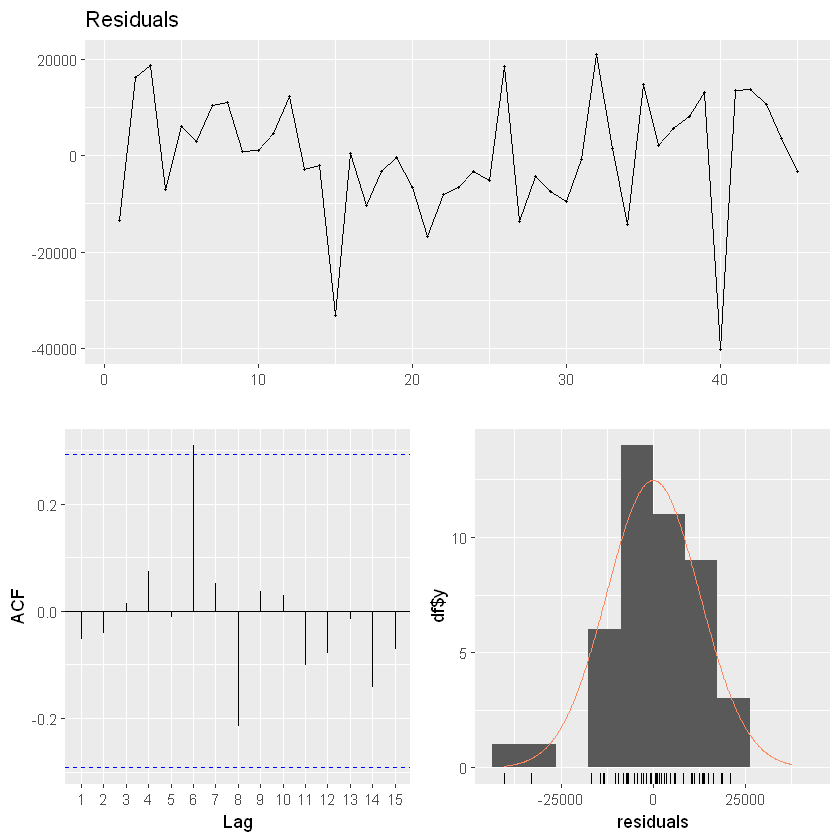

In [177]:
checkresiduals(model2)

Checking the residuals after the modelling process in order to determine some unexplained features of the data shows us that the residuals have unsignificant autocorrelation and also a mean close to zero, while they fail to satisfy normal distribution assumption.

The second data chosen to be modelled is the thounds of people that are unemployed in Turkey. 
It will be examined that if there is a linear relation between searches for job postings and the unemployed people amount.

In [178]:
dt2 <- data.table()
dt2[,'date':= dt[,'Tarih']]
dt2[,'unemployment':= dt[,'TP.YISGUCU2.G4']]

start_month <- "2020-01"
end_month <- "2024-01"

x1 <- fread('işilanı.csv')
x1[, Month := format(Hafta, "%Y-%m")]
x1 <- x1[, .(Sum = sum(`iş ilanı: (Türkiye)`)), by = Month]
x1 <- x1[Month %between% c(start_month, end_month)]

dt2[,'search_jobs':= x1[,'Sum']]
dt2$t <- 1:nrow(dt)

head(dt2)

date,unemployment,search_jobs,t
<chr>,<dbl>,<int>,<int>
2020-01,4420,274,1
2020-02,4239,252,2
2020-03,3905,217,3
2020-04,3698,105,4
2020-05,3692,217,5
2020-06,4028,238,6


Before building models the individual data sets are plotted as the previous case.

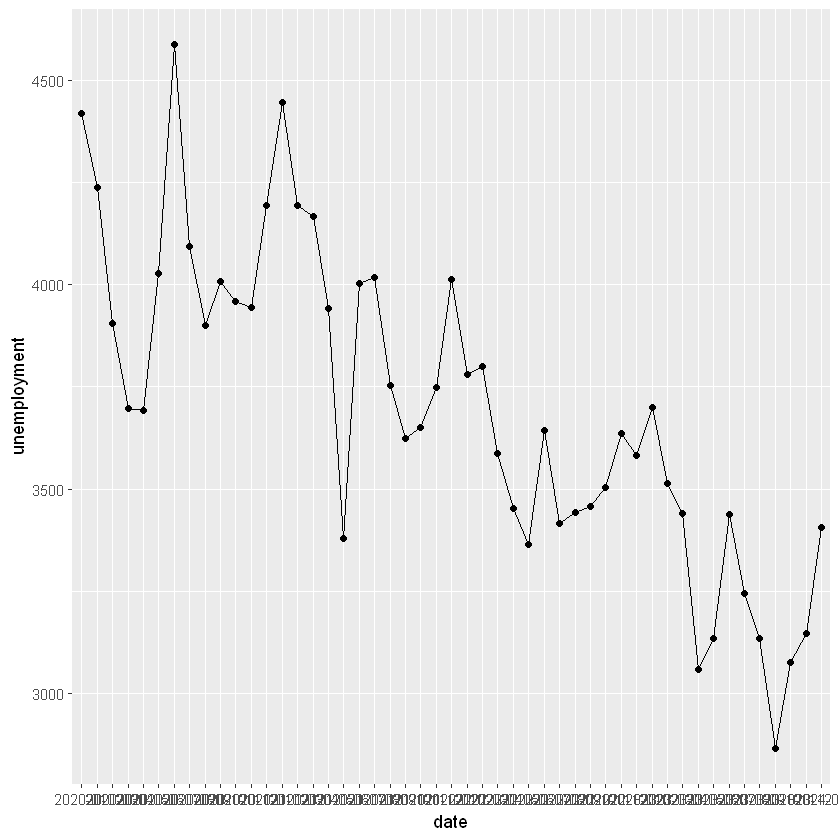

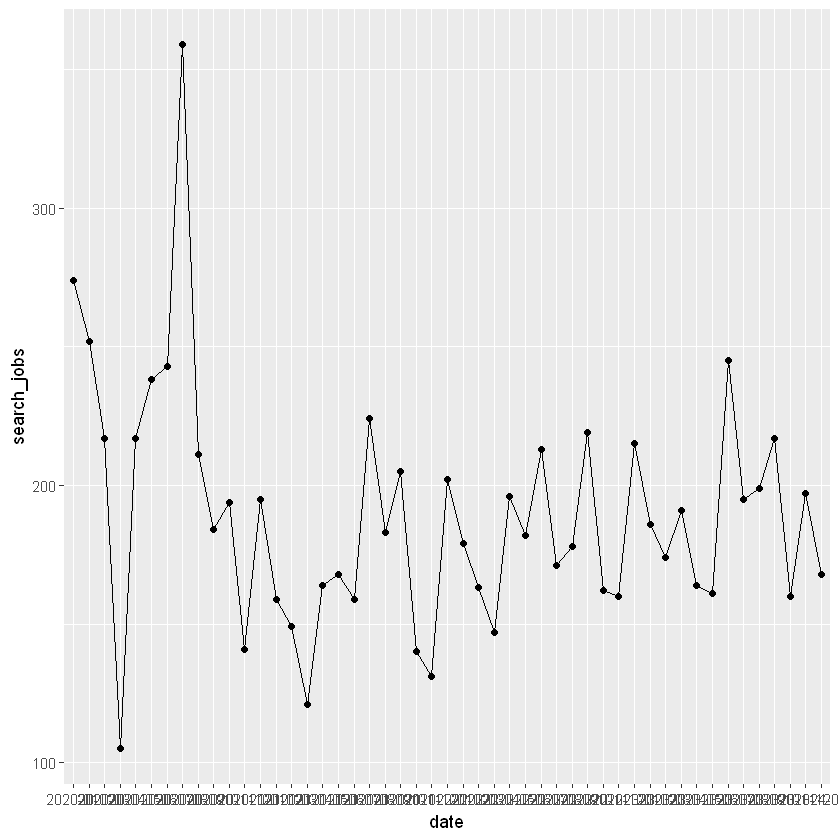

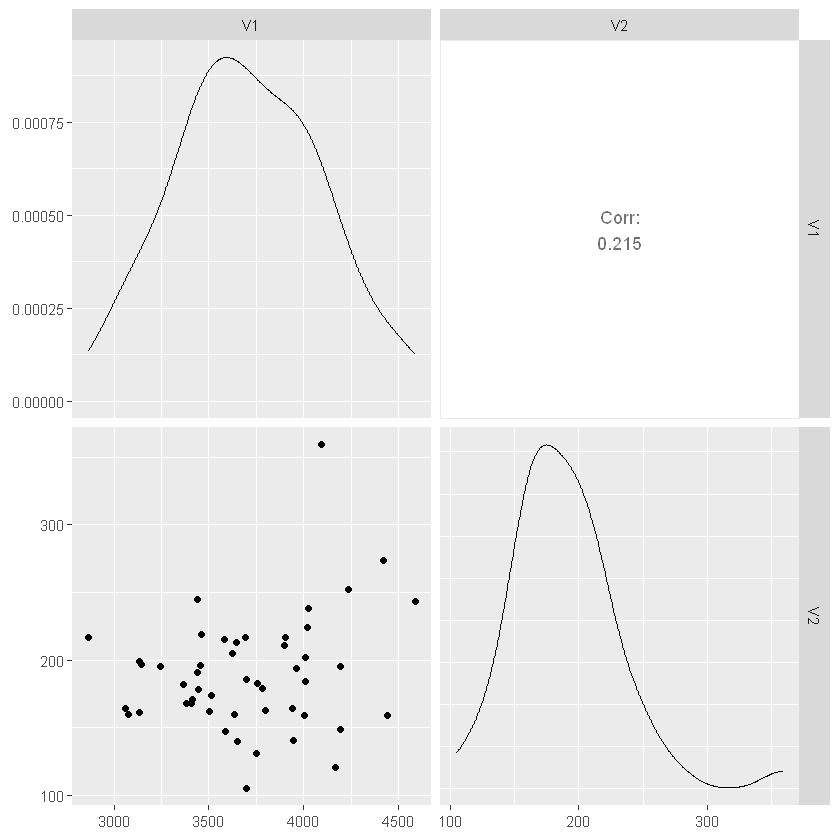

In [179]:
ggplot(dt2, aes(x = date, y = unemployment, group=1)) + geom_line() + geom_point()
ggplot(dt2, aes(x = date, y = search_jobs, group=1)) + geom_line() + geom_point()

matrix3 <- data.table(dt2[,unemployment],dt2[,search_jobs])
ggpairs(matrix3)

It is clearly observable by visual inspection that the number of unemployed people generally are decreasing with time in other words has a downwards trend. Therefore, the forecast variable is modelled with a trend variable besides the google search data.

In [180]:
model3 <- lm(unemployment ~ t + search_jobs , data = dt2)
summary(model3)


Call:
lm(formula = unemployment ~ t + search_jobs, data = dt2)

Residuals:
    Min      1Q  Median      3Q     Max 
-468.61 -128.96  -25.94  150.93  511.72 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) 4176.0599   172.8574  24.159  < 2e-16 ***
t            -22.1132     2.3310  -9.487 2.12e-12 ***
search_jobs    0.4202     0.7810   0.538    0.593    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 225.7 on 46 degrees of freedom
Multiple R-squared:  0.6774,	Adjusted R-squared:  0.6633 
F-statistic: 48.29 on 2 and 46 DF,  p-value: 5.014e-12


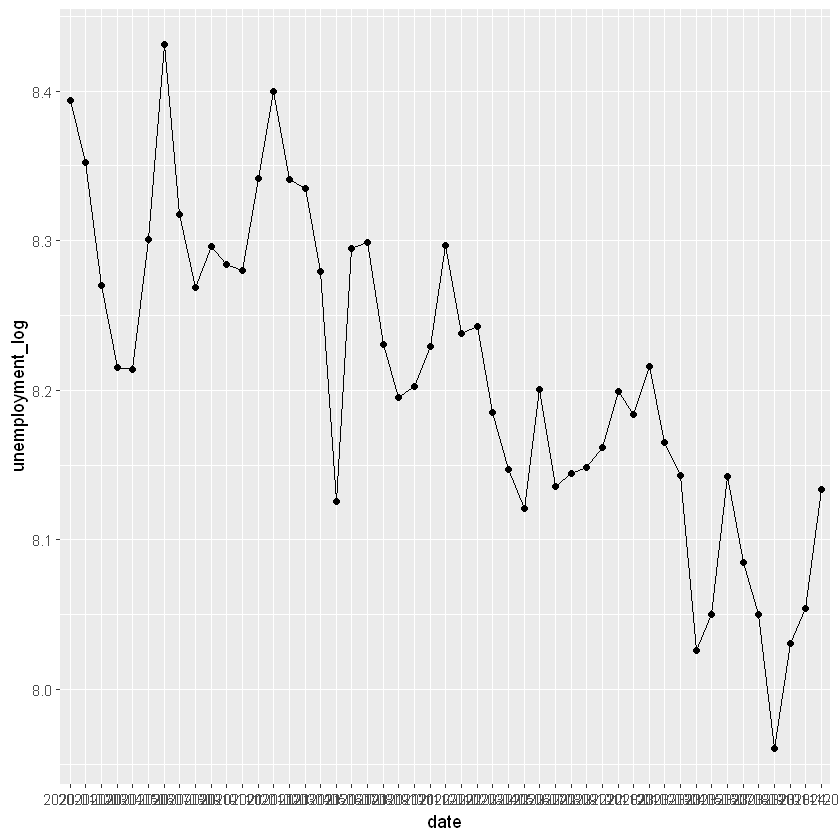

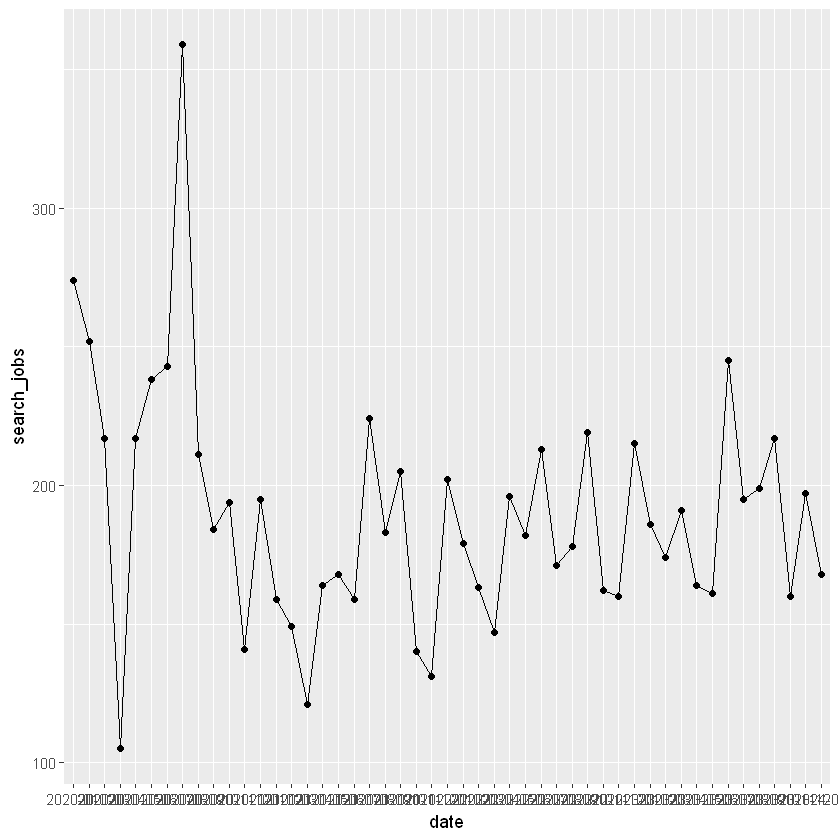

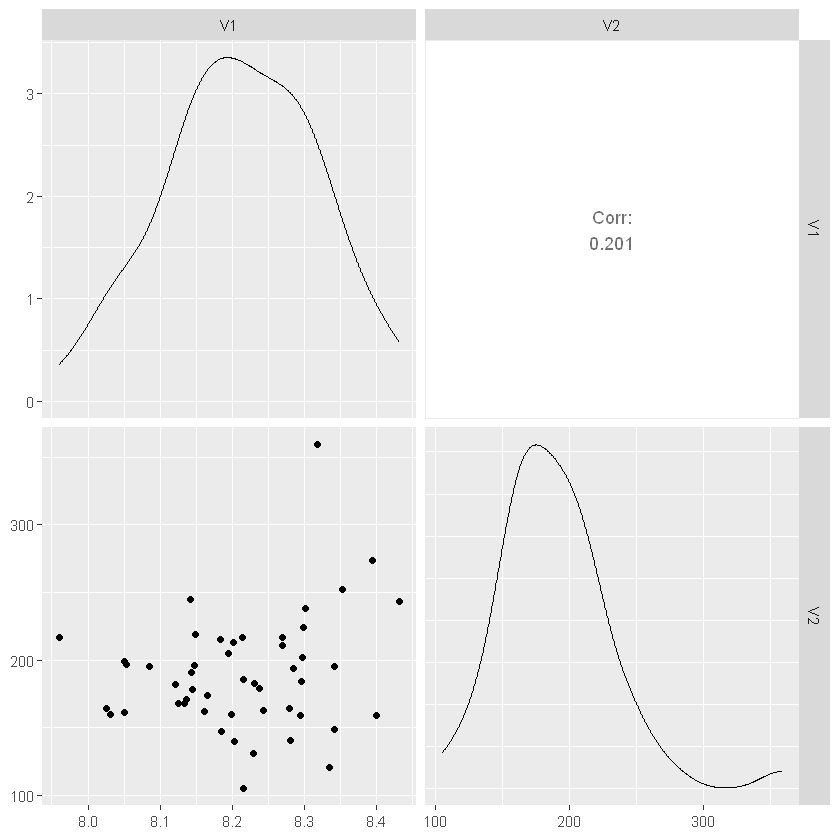

In [181]:
dt2[, unemployment_log:= log(unemployment)]
ggplot(dt2, aes(x = date, y = unemployment_log, group=1)) + geom_line() + geom_point()
ggplot(dt2, aes(x = date, y = search_jobs, group=1)) + geom_line() + geom_point()

matrix3 <- data.table(dt2[,unemployment_log],dt2[,search_jobs])
ggpairs(matrix3)

In [182]:
model4 <- lm(unemployment_log ~ t + search_jobs , data = dt2)
summary(model4)


Call:
lm(formula = unemployment_log ~ t + search_jobs, data = dt2)

Residuals:
      Min        1Q    Median        3Q       Max 
-0.126546 -0.035696 -0.004662  0.043303  0.123811 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)  8.348e+00  4.667e-02 178.895  < 2e-16 ***
t           -6.057e-03  6.293e-04  -9.626 1.35e-12 ***
search_jobs  7.583e-05  2.109e-04   0.360    0.721    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.06094 on 46 degrees of freedom
Multiple R-squared:  0.6816,	Adjusted R-squared:  0.6678 
F-statistic: 49.24 on 2 and 46 DF,  p-value: 3.702e-12


Since the plot of the unemployement data shows increasing varience with time a logaritmic transformation is applied.
However, no noticable improvement can be observed in terms of R-squared value and linear relationship between target and regressor variable.

Lastly, the data of the amount of gold that is imported by Turkey will be explored using the time series data of the google searches for gold prices and wedding venues. The reasoning behind it is that people generally buy gold as a wedding gift. Therefore, a relation may be observed between the gold puschase and weddings.

In [183]:
dt3 <- data.table()
dt3[,'date':= dt[,'Tarih']]
dt3[,'gold_import':= dt[,'TP.GOLDIMPRT.V1']]

start_month <- "2020-01"
end_month <- "2024-01"

x1 <- fread('düğünsalonu.csv')
x1[, Month := format(Hafta, "%Y-%m")]
x1 <- x1[, .(Sum = sum(`Düğün Salonu: (Türkiye)`)), by = Month]
x1 <- x1[Month %between% c(start_month, end_month)]

x2 <- fread('altınfiyatları.csv')
x2[, Month := format(Hafta, "%Y-%m")]
x2 <- x2[, .(Sum = sum(`altın fiyatları: (Türkiye)`)), by = Month]
x2 <- x2[Month %between% c(start_month, end_month)]


dt3[,'search_wedding_venues':= x1[,'Sum']]
dt3[,'search_gold_prices':= x2[,'Sum']]
dt3$t <- 1:nrow(dt)

head(dt3)

date,gold_import,search_wedding_venues,search_gold_prices,t
<chr>,<dbl>,<int>,<int>,<int>
2020-01,29647.63,161,56,1
2020-02,18872.63,98,68,2
2020-03,26268.15,109,86,3
2020-04,7308.34,19,59,4
2020-05,11779.97,44,65,5
2020-06,21518.34,36,54,6


Same plots as before are created for this data before the modelling process as well.

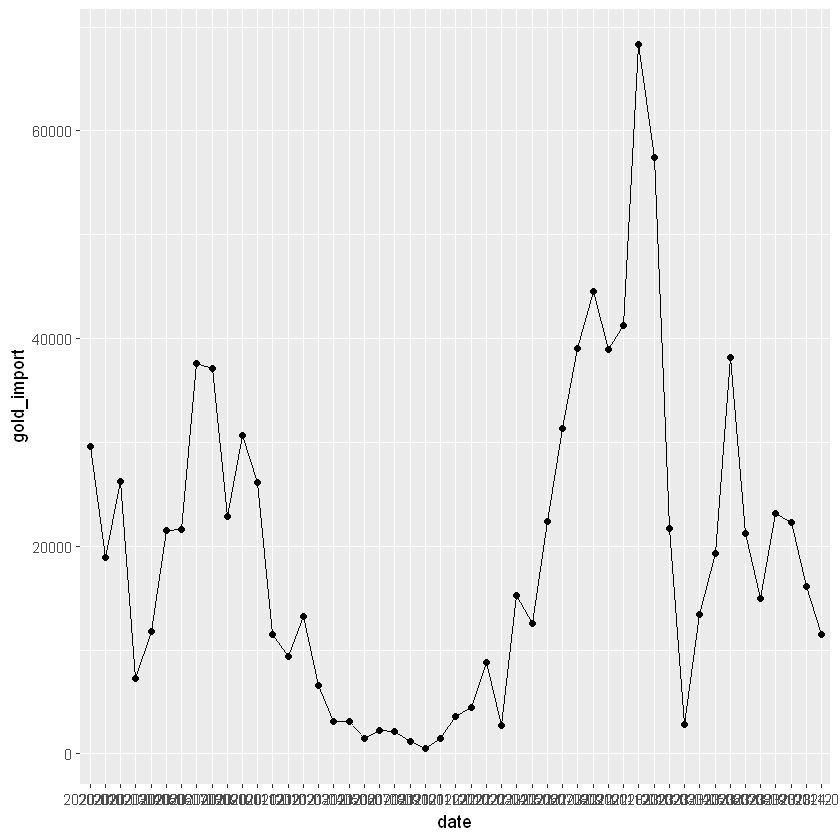

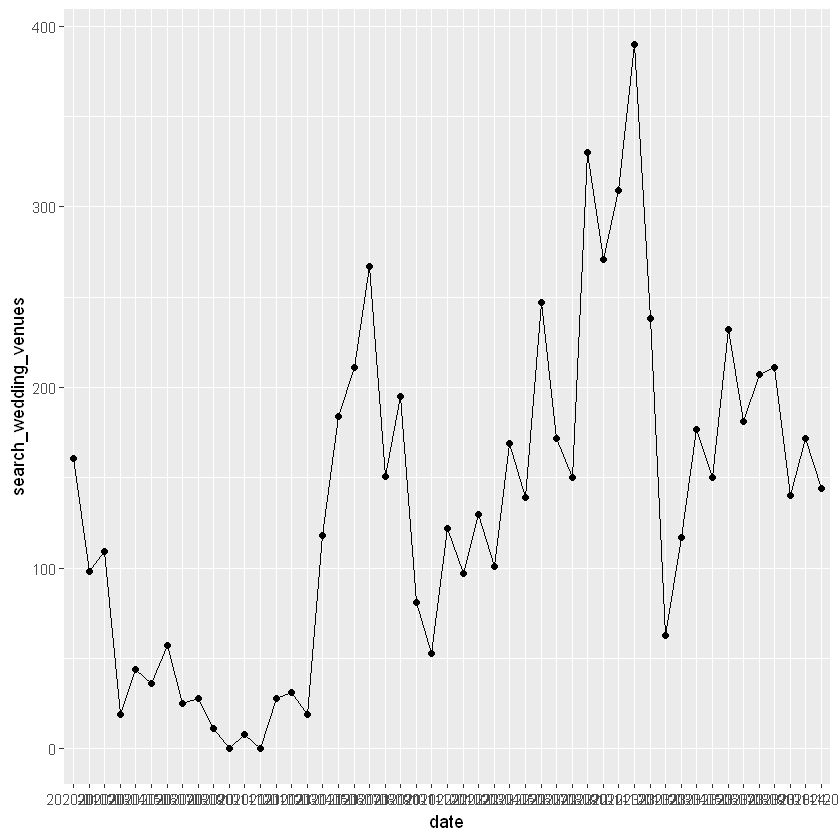

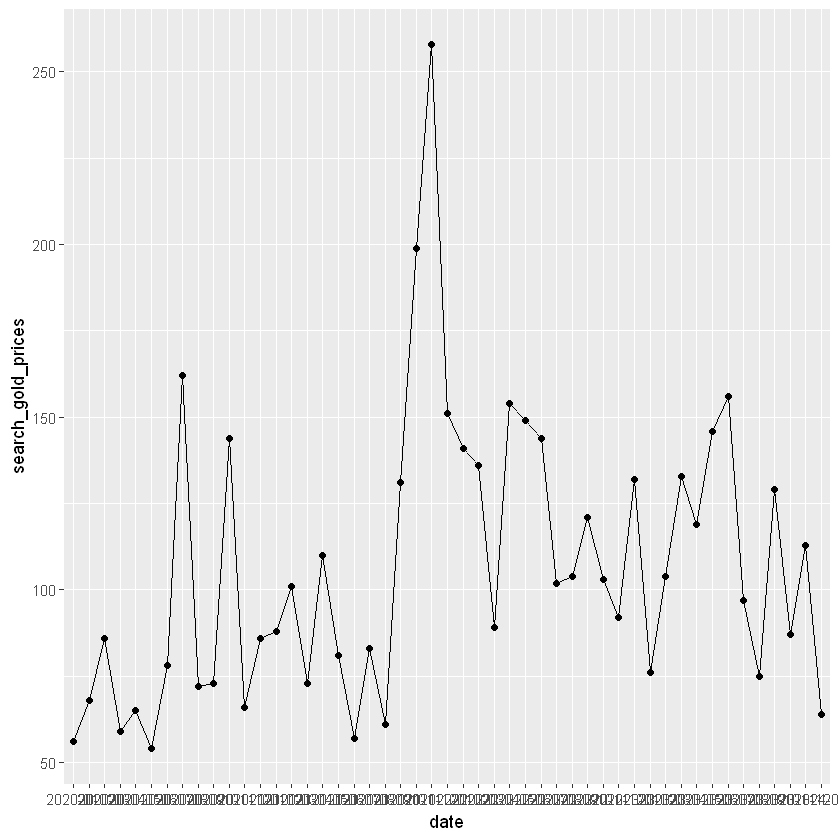

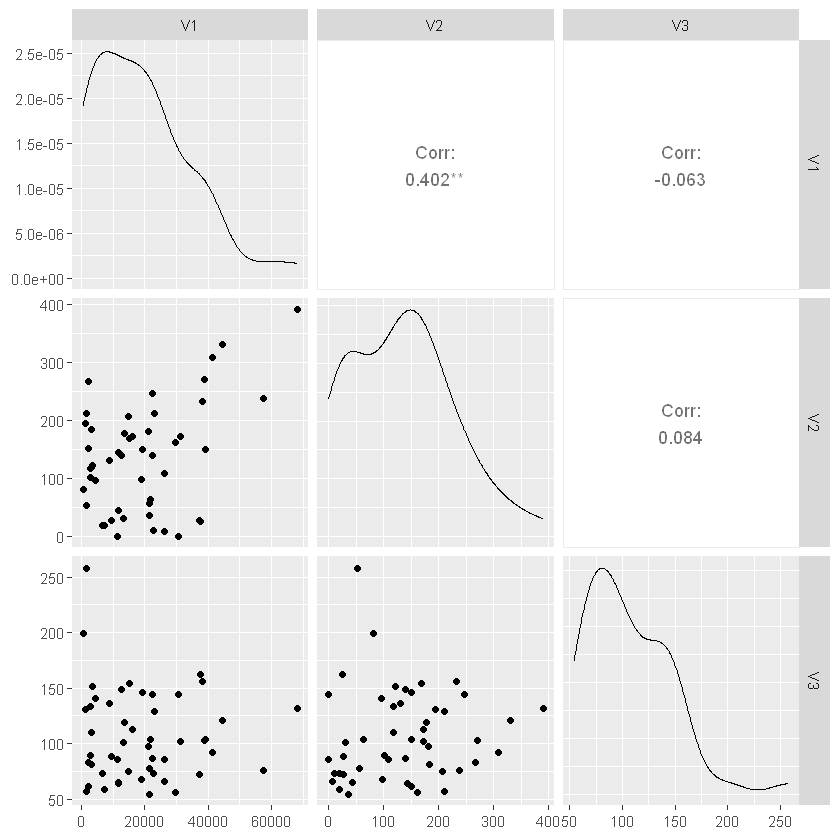

In [184]:
ggplot(dt3, aes(x = date, y = gold_import, group=1)) + geom_line() + geom_point()
ggplot(dt3, aes(x = date, y = search_wedding_venues, group=1)) + geom_line() + geom_point()
ggplot(dt3, aes(x = date, y = search_gold_prices, group=1)) + geom_line() + geom_point()

matrix4 <- data.table(dt3[,gold_import],dt3[,search_wedding_venues],dt3[,search_gold_prices])
ggpairs(matrix4)

Correlation coefficient seems high for the wedding venues search, so only it will be included in the model. No trend is observed from the data.


Call:
lm(formula = gold_import ~ search_wedding_venues, data = dt3)

Residuals:
   Min     1Q Median     3Q    Max 
-25829 -10172  -1164   9603  32022 

Coefficients:
                      Estimate Std. Error t value Pr(>|t|)   
(Intercept)           10245.67    3627.78   2.824  0.00693 **
search_wedding_venues    66.83      22.22   3.007  0.00422 **
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 14380 on 47 degrees of freedom
Multiple R-squared:  0.1614,	Adjusted R-squared:  0.1435 
F-statistic: 9.044 on 1 and 47 DF,  p-value: 0.004223



	Breusch-Godfrey test for serial correlation of order up to 10

data:  Residuals
LM test = 35.141, df = 10, p-value = 0.0001182


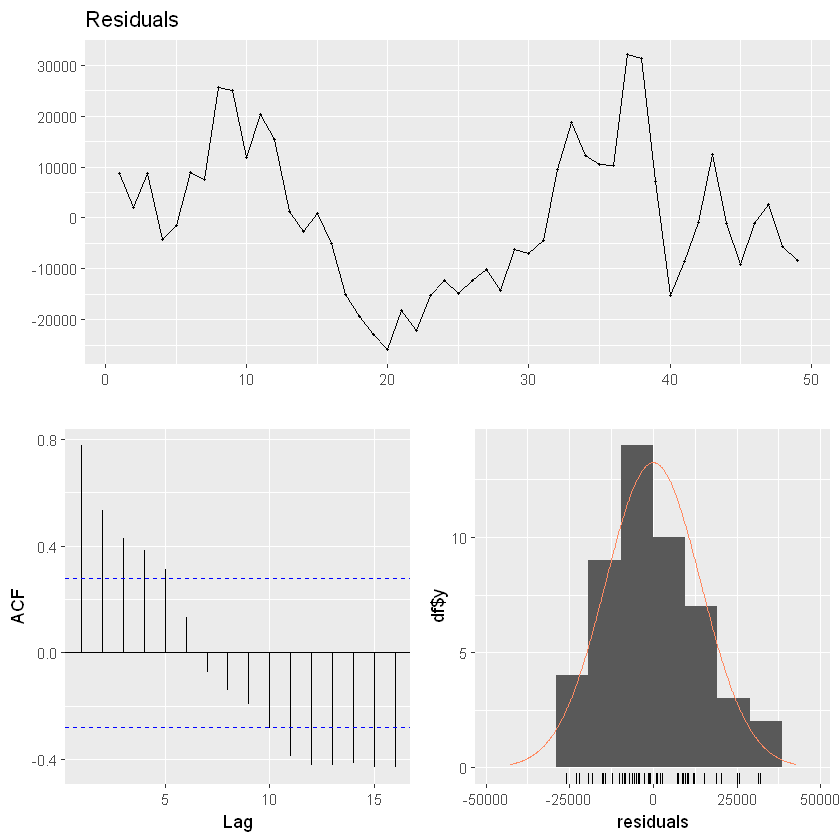

In [185]:
model5 <- lm(gold_import ~ search_wedding_venues, data = dt3)
summary(model5)
checkresiduals(model5)

Observing the scatterplot of imported gold versus wedding venue searches it can be seen that the relation is not just linear. Hence the square of the independent variable is also added to the model to achieve a better model.

 Additionaly, when residuals of the model are checked, it can be seen that a seasonality component remains in the residuals according to the plot and also the autocorrelation function.

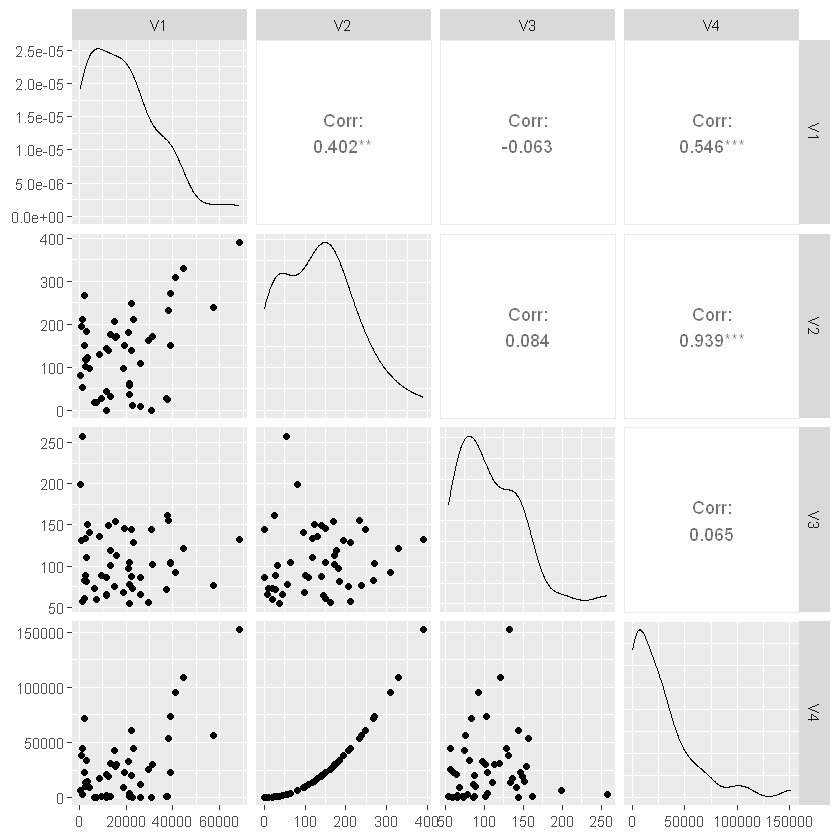

In [190]:
dt3[, search_wedding_venues_square := dt3[,search_wedding_venues]^2]
matrix4 <- data.table(dt3[,gold_import],dt3[,search_wedding_venues],dt3[,search_gold_prices],dt3[,search_wedding_venues_square])
ggpairs(matrix4)


Call:
lm(formula = gold_import ~ search_wedding_venues + search_wedding_venues_square, 
    data = dt3)

Residuals:
   Min     1Q Median     3Q    Max 
-27797  -9734   -845   6783  33202 

Coefficients:
                               Estimate Std. Error t value Pr(>|t|)    
(Intercept)                  21429.6784  4047.7101   5.294 3.25e-06 ***
search_wedding_venues         -156.0195    55.2606  -2.823    0.007 ** 
search_wedding_venues_square     0.7053     0.1643   4.294 8.97e-05 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 12280 on 46 degrees of freedom
Multiple R-squared:  0.4013,	Adjusted R-squared:  0.3753 
F-statistic: 15.42 on 2 and 46 DF,  p-value: 7.507e-06



	Breusch-Godfrey test for serial correlation of order up to 10

data:  Residuals
LM test = 25.281, df = 10, p-value = 0.004837


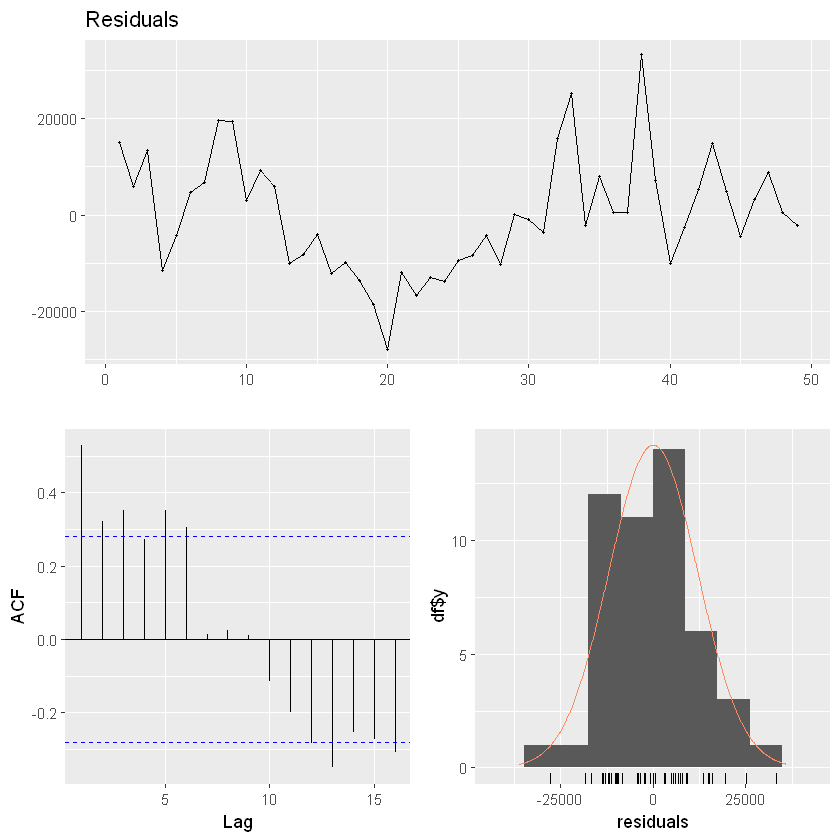

In [192]:
model6 <- lm(gold_import ~ search_wedding_venues + search_wedding_venues_square, data = dt3)
summary(model6)
checkresiduals(model6)

Adjusted R-squared value increased from 14% to 37.5% after this variable addition to the model.
Evaluating the result of the linear regression model, all of the independent variables being searches for wedding venues, its square and the intercept variable have a significant linear relationship with the variable of interest.

To implement seasonality component into the model dummy variables are created as one hot encoding of the months.

In [193]:
dt3[,'month':= dt3[,'t']%%12]
dummies <- model.matrix(~ 0 + factor(dt3$month))
dummy_dt <- as.data.table(dummies)
dt3 <- cbind(dt3, dummy_dt)


Call:
lm(formula = gold_import ~ search_wedding_venues + search_wedding_venues_square + 
    factor(dt3$month), data = dt3)

Residuals:
   Min     1Q Median     3Q    Max 
-30776  -7489   1341   6137  28131 

Coefficients:
                               Estimate Std. Error t value Pr(>|t|)    
(Intercept)                  20951.7499  7360.1612   2.847 0.007342 ** 
search_wedding_venues         -177.6735    62.2450  -2.854 0.007198 ** 
search_wedding_venues_square     0.7614     0.1873   4.065 0.000259 ***
factor(dt3$month)1             458.0759  8713.0083   0.053 0.958370    
factor(dt3$month)2            7524.7971  9245.9249   0.814 0.421233    
factor(dt3$month)3            4911.3789  9323.2238   0.527 0.601663    
factor(dt3$month)4           -9401.9607  9307.2121  -1.010 0.319342    
factor(dt3$month)5           -1904.2897  9360.0608  -0.203 0.839963    
factor(dt3$month)6            1115.8311  9351.1643   0.119 0.905700    
factor(dt3$month)7            2175.7853  9321.1095   0.2


	Breusch-Godfrey test for serial correlation of order up to 17

data:  Residuals
LM test = 36.857, df = 17, p-value = 0.003519


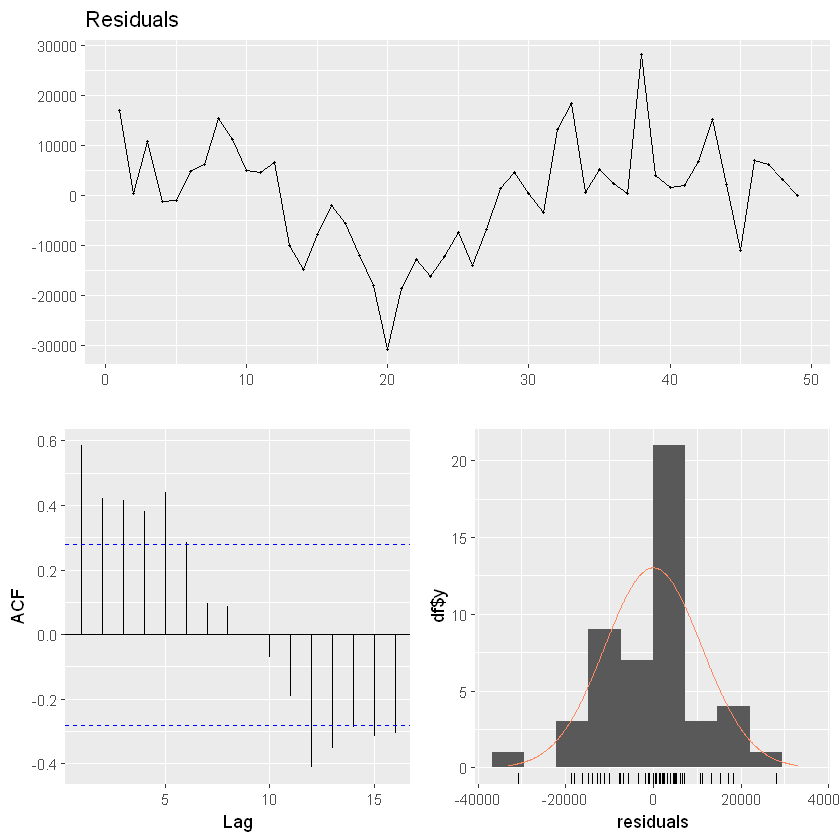

In [197]:
model5 <- lm(gold_import ~ search_wedding_venues + search_wedding_venues_square + factor(dt3$month), data = dt3)
summary(model5)
checkresiduals(model5)

None of the dummy variables seem significant according to their p-values. Also, no improvement can be achieved in terms of adjusted R-squared value or the structure of the residuals. Therefore, the categorical variables can be dropped.